Let us look at the predictions made by our simple NN from previous notebook.

In [158]:
import torch
from torch import nn
import matplotlib.pyplot as plt

import linear_regression, utils

In [159]:
torch.manual_seed(42)
lin_reg_model = linear_regression.Linear_Regresssion_Model()

In [160]:
X = torch.arange(1,10.1,0.5)
X = X.unsqueeze(dim = 1)
weight = 0.3
bias = 0.9
y = weight * X + bias
y


tensor([[1.2000],
        [1.3500],
        [1.5000],
        [1.6500],
        [1.8000],
        [1.9500],
        [2.1000],
        [2.2500],
        [2.4000],
        [2.5500],
        [2.7000],
        [2.8500],
        [3.0000],
        [3.1500],
        [3.3000],
        [3.4500],
        [3.6000],
        [3.7500],
        [3.9000]])

In [161]:
train_split = int(0.6 * len(X))
train_X, train_y = X[:train_split], y[:train_split]
test_X, test_y = X[train_split:], y[train_split:]
test_X, test_y

(tensor([[ 6.5000],
         [ 7.0000],
         [ 7.5000],
         [ 8.0000],
         [ 8.5000],
         [ 9.0000],
         [ 9.5000],
         [10.0000]]),
 tensor([[2.8500],
         [3.0000],
         [3.1500],
         [3.3000],
         [3.4500],
         [3.6000],
         [3.7500],
         [3.9000]]))

In [162]:
# predictions = lin_reg_model(test_X)

# using context manager to make inference
with torch.inference_mode():
    predictions = lin_reg_model(test_X)

predictions

tensor([[2.3173],
        [2.4856],
        [2.6540],
        [2.8223],
        [2.9907],
        [3.1590],
        [3.3274],
        [3.4957]])

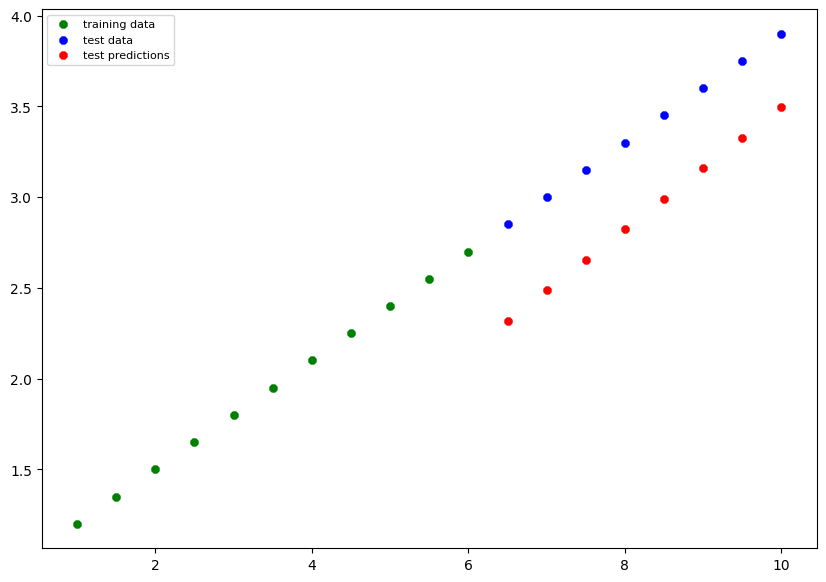

In [163]:
# if context manager was not used while making predictions above
#utils.plot_predictions(train_X, train_y, test_X, test_y, predictions.detach().numpy())

# if context manager used above
utils.plot_predictions(train_X, train_y, test_X, test_y, predictions)

#### Train the model
One way to measure how bad the predictions are is to use the loss functions. `torch.nn` has many pre-defined loss functions such as L1 loss, L2 loss, CrossEntropy loss, etc. In order to train a model based on how bad the current predictions are according to a loss function, we need an optimizer that tries to minimize the error in terms of the loss function. torch has `torch.optim` module that makes many optimizers such as `torch.optim.SGD` available.

Set up a loss function.

In [164]:
loss_func = nn.MSELoss()
loss_func

MSELoss()

Set up an optimizer.

In [165]:
optimizer = torch.optim.SGD(params = lin_reg_model.parameters(),
                             lr = 0.0001)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Set up the training and testing loop.

In [166]:
torch.manual_seed(42)

epochs = 100000
epoch_ctr = []
training_loss_list = []
test_loss_list = []

# for each pass of the training data
for epoch in range(0, epochs):        

    ###### TRAINING SECTION
    # set the model to training mode
    lin_reg_model.train()

    # make predictions for all training data
    predictions = lin_reg_model(train_X)
    
    # calculate the training loss
    training_loss = loss_func(predictions, train_y)
    
    # clear the garbage gradient value
    optimizer.zero_grad()
    
    # calculate the gradients using backpropagation for the entire dataset at once
    # hence, this is not Stochastic Gradient Descent, but rather Gradient Descent
    training_loss.backward()
    
    # update model parameters using the calculated gradients
    optimizer.step()

    ###### EVALUATION SECTION

    # set the model to evaluation mode
    # this ensures that any calculation that is not needed in the test mode is skipped
    # such as batch norm or dropout operations
    lin_reg_model.eval()
    
    # evaluate the model after the parameter update
    if epoch % 10000 == 0:

        # inference mode ensures that the gradients are not tracked within this with loop
        with torch.inference_mode():

            # make predictions for test data
            test_predictions = lin_reg_model(test_X)

            # calculate the loss
            test_loss = loss_func(test_predictions, test_y)
            print("\nEPOCH ", epoch, " | Training loss: ",training_loss.detach().item()," | Test loss at epoch ", epoch, ":", test_loss.item())
            #print(lin_reg_model.state_dict())
            # store the training and test loss for the plot
            epoch_ctr.append(epoch)
            training_loss_list.append(training_loss.detach())
            test_loss_list.append(test_loss)





EPOCH  0  | Training loss:  0.41652432084083557  | Test loss at epoch  0 : 0.21785318851470947

EPOCH  10000  | Training loss:  0.048574019223451614  | Test loss at epoch  10000 : 0.29621651768684387

EPOCH  20000  | Training loss:  0.0255757924169302  | Test loss at epoch  20000 : 0.15596812963485718

EPOCH  30000  | Training loss:  0.013466776348650455  | Test loss at epoch  30000 : 0.08212758600711823

EPOCH  40000  | Training loss:  0.007091249339282513  | Test loss at epoch  40000 : 0.04324725642800331

EPOCH  50000  | Training loss:  0.0037342750001698732  | Test loss at epoch  50000 : 0.022776316851377487

EPOCH  60000  | Training loss:  0.001966724405065179  | Test loss at epoch  60000 : 0.011997612193226814

EPOCH  70000  | Training loss:  0.0010359493317082524  | Test loss at epoch  70000 : 0.006320618558675051

EPOCH  80000  | Training loss:  0.000545599905308336  | Test loss at epoch  80000 : 0.003326962236315012

EPOCH  90000  | Training loss:  0.000287561968434602  | Tes

As seen above, training for more epochs reduces the test loss in general, heading toward 0. However, over-training will cause the test loss to increase if the learning rate is not gradually reduced.

#### Plots

Prediction vs. Ground Truth

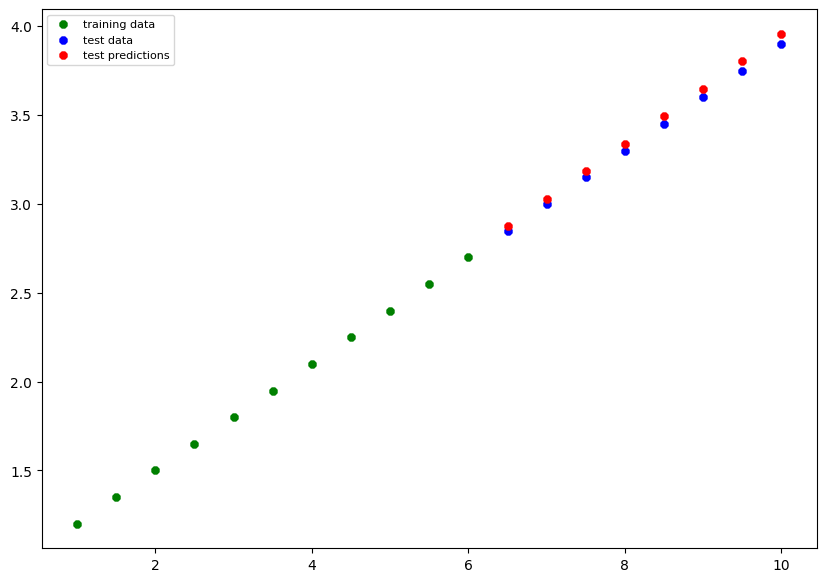

In [167]:
# plot the predictions vs the ground truth at the end
utils.plot_predictions(train_X, train_y, test_X, test_y, test_predictions)

As seen above, our model has learned a decent estimation of the simple linear regression parameters such that the predictions (in red) are much closed to the ground truth (in blue) than from where we started. 

Training Loss vs Test Loss

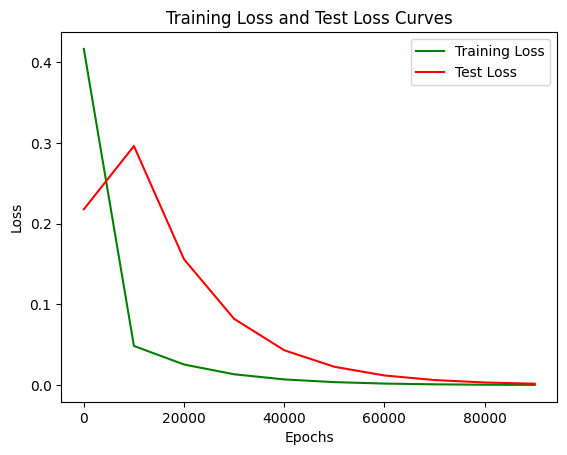

In [172]:
plt.plot(epoch_ctr, training_loss_list, "g", label = "Training Loss")
plt.plot(epoch_ctr, test_loss_list, "r", label = "Test Loss")
plt.title("Training Loss and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

As seen above, the training and test loss values gradually decrease over the epochs.

#### Save the trained model so as to re-use later.
- `torch.save()` saves a PyTorch object in .pkl format
    - This includes a `torch.nn.Module` object (a NN in torch) and a `torch.optim.SGD` object.
- `torch.load()` - loads a saved PyTorch object.
- `torch.nn.Module.load_state_dict()` allows a saved model parameters to be loaded to a torch NN.

In [181]:
path_to_save_model = "saved_params\lin_reg_model_params.pth"

# save the model and optimizer's state dicts
torch.save(lin_reg_model.state_dict(), path_to_save_model)

Load a saved model.

In [184]:
new_model = linear_regression.Linear_Regresssion_Model()
new_model.state_dict() 


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [186]:
new_model.load_state_dict(torch.load(path_to_save_model))

<All keys matched successfully>

New predictions can be made using this loaded model.

In [191]:
# predict using both models to compare side-by-side
lin_reg_model.eval()
new_model.eval()
with torch.inference_mode():
    print(lin_reg_model(test_X))
    print(new_model(test_X))

tensor([[2.8667],
        [3.0203],
        [3.1739],
        [3.3275],
        [3.4811],
        [3.6346],
        [3.7882],
        [3.9418]])
tensor([[2.8667],
        [3.0203],
        [3.1739],
        [3.3275],
        [3.4811],
        [3.6346],
        [3.7882],
        [3.9418]])


In [193]:
lin_reg_model(test_X) == new_model(test_X)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

As seen above, both, the original model and the saved model, provide the same predictions.